In [1]:
import torch
import scanpy as sc
import anndata as ad
import scDiffusion as sd


/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
REF_PATH = 'reference/'
DATA_PATH = 'data/'
OUTPUT_PATH = 'outputs/'

# Load dataset

In [4]:
adata_ref = sc.read_h5ad(REF_PATH + 'pbmc_ref.h5ad')  # Reference 
adata_query = sc.read_h5ad(DATA_PATH + 'pbmc.h5ad')     # Query Data


In [5]:
# 'ref_label' represents the reference cell identities. For Query Data, set as "NewData" 
adata_ref.obs['ref_label']=adata_ref.obs['labels']
adata_query.obs['ref_label']= 'NewData'

In [6]:
# 'batch' represent the batch information.
adata_ref.obs['batch']= 'Reference'
adata_query.obs['batch']= 'New'

In [7]:
# Combine Reference and New Data
adata = ad.concat([adata_query, adata_ref], merge='same')

# Preprocess

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


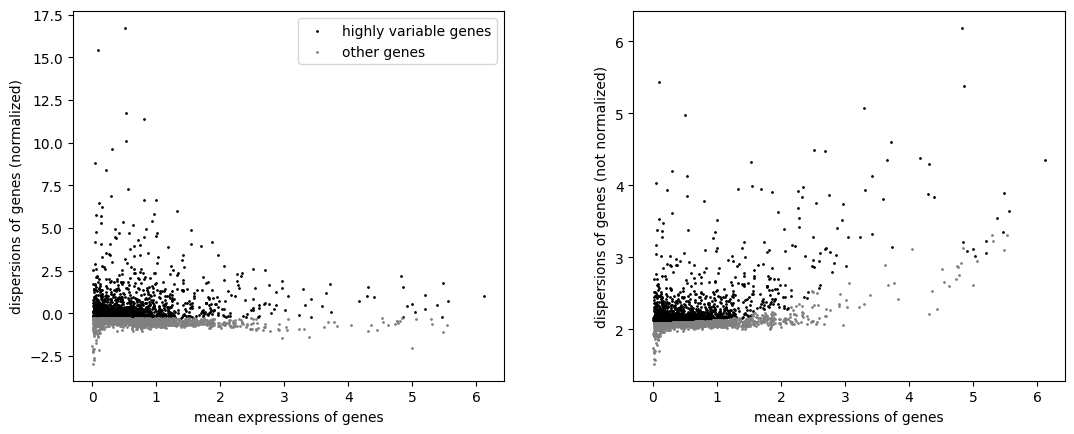

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [9]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

adata

View of AnnData object with n_obs × n_vars = 10231 × 2000
    obs: 'ref_label', 'batch'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

We use the normalized and log transformed data (NOT scaled data).

# Feature encoder

In [10]:
sd.encode_features(adata, 
                D_encode_list=[2000, 300, 50], 
                D_decode_list=[50, 300, 2000], 
                max_epoch=2000, 
                lr=1e-3, 
                device=device)


2024-11-07 14:16:09,267 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2024-11-07 14:16:10,460 - ------------------------> Epoch: 1/2000, Current loss: 17008804.0000
2024-11-07 14:16:11,262 - ------------------------> Epoch: 51/2000, Current loss: 7366525.0000
2024-11-07 14:16:12,055 - ------------------------> Epoch: 101/2000, Current loss: 7077625.0000
2024-11-07 14:16:12,861 - ------------------------> Epoch: 151/2000, Current loss: 6883969.5000
2024-11-07 14:16:13,661 - ------------------------> Epoch: 201/2000, Current loss: 6733079.5000
2024-11-07 14:16:14,457 - ------------------------> Epoch: 251/2000, Current loss: 6641582

## view encoded embeddings

In [11]:
sc.pp.neighbors(adata, use_rep='X_fae', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


... storing 'ref_label' as categorical
... storing 'batch' as categorical


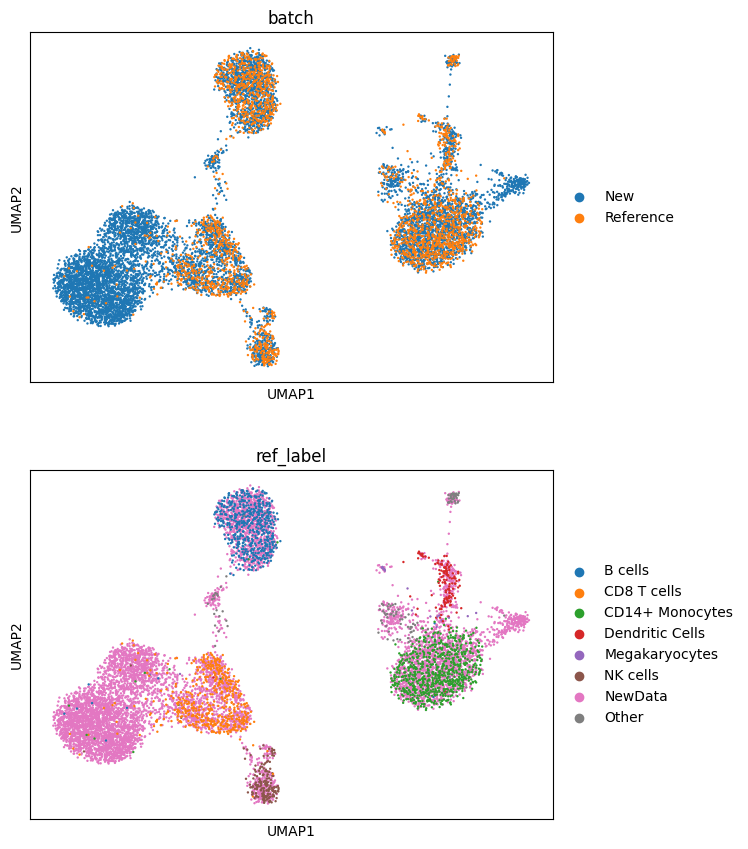

In [12]:
sc.pl.umap(adata, color=['batch', 'ref_label'],ncols=1)

# Integration

In [13]:
# Due to high memory demands, consider using 'cpu' as a fallback if 'cuda' runs out of memory. 
# Although 'cpu' execution is slower, it can handle the task more efficiently in such cases and 
# typically completes in a few minutes.

sd.inte.evaluate_batch_isolation(adata, 
                            batch_key='batch', 
                            use_rep = 'X_fae',
                            device=device)

In [14]:
# This step requires adata.obs['batch'] information. You can simply set adata.obs['batch']=adata.obs[batch_key] if batch_key!='batch'.

sd.inte.build_integration_graph(adata, use_rep='X_fae', n_edges_per_node=50, device=device)

In [15]:
sd.inte.build_integration_loss_adj(adata, use_rep='X_fae', k=50, device=device)

In [16]:
sd.inte.integration_diffusion(adata, 
                              use_rep='X_fae',
                              max_epoch=2000, 
                              lr=1e-3, 
                              time_increment_diffusion=0.2,
                              device=device)


2024-11-07 14:17:17,629 - --------> Starting data integration ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/sc_integration/integration_DIF.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2024-11-07 14:17:17,780 - ------------------------> Epoch: 1/2000, Current loss: 8245919744.0000
2024-11-07 14:17:23,824 - ------------------------> Epoch: 51/2000, Current loss: 68034648.0000
2024-11-07 14:17:29,888 - ------------------------> Epoch: 101/2000, Current loss: 54617692.0000
2024-11-07 14:17:35,950 - ------------------------> Epoch: 151/2000, Current loss: 51996928.0000
2024-11-07 14:17:42,014 - ------------------------> Epoch: 201/2000, Current loss: 50753428.0000
2024-11-07 14:17:48,081 - ------------------------> Epoch: 251/2000, Curren

## View integrated embeddings

In [17]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

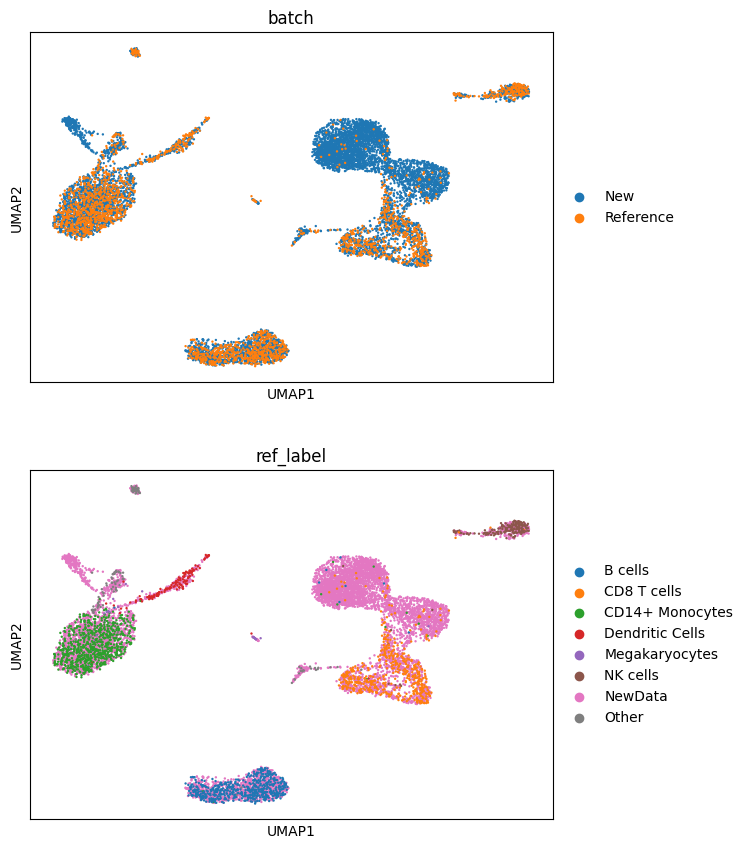

In [18]:
sc.pl.umap(adata, color=['batch', 'ref_label'],ncols=1)

# Annotation

In [19]:
sd.anal.transfer_annotation(adata,   # Anndata object that combines Reference and New Data 
           use_rep='X_dif',        # the embeddings used to build the label transfer graph
           use_label='ref_label',     # For Reference, it should be cell identities to be transfer; For New Data, could be labeled as "New".
           batch_key='batch',     # The key to distinguish Reference and New Data. 
           ref_batch='Reference',     # the batch label for Reference used in 'batch_key'
           data_batch='New',        # the batch label for New Data used in 'batch_key'
           n_edges_per_node=50,   # K-value in KNN graph or MNN graph
           use_mnn=False,       # if use MNN to build graph     
           device=device    # 'cpu' or 'cuda'
                    )

... storing 'batch_labels' as categorical
... storing 'transfered_labels' as categorical
... storing 'reference_alignment' as categorical


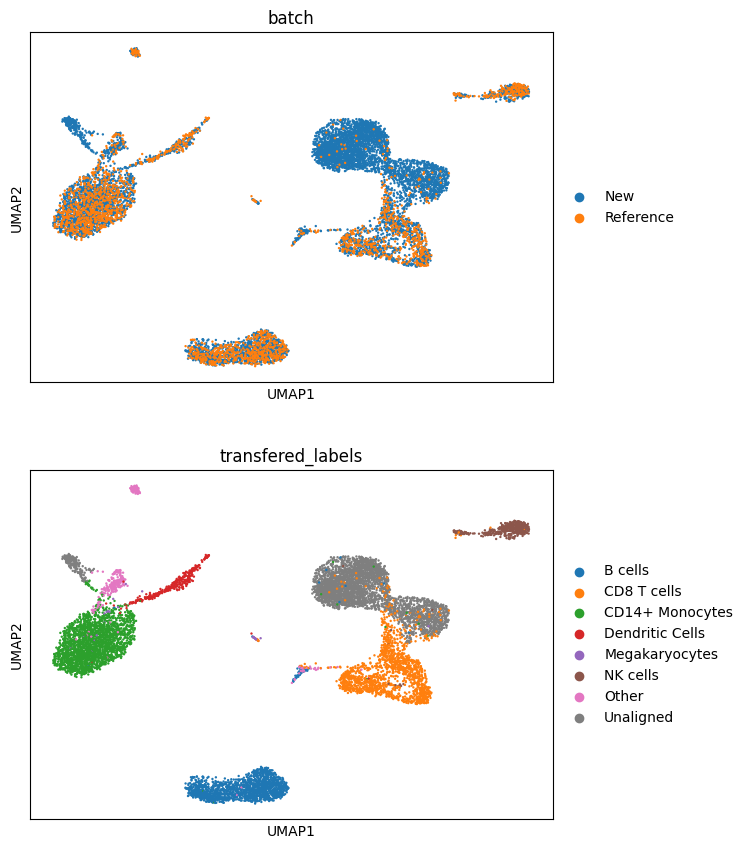

In [20]:
sc.pl.umap(adata, color=['batch', 'transfered_labels'],ncols=1)

Unaligned cells are those that cannot find counterparts in the reference data. These cells may represent cell types that are not present in the reference data.

# Save data

In [21]:
adata.write(OUTPUT_PATH+'annotated_adata.h5ad')

In [22]:
adata = ad.read_h5ad(OUTPUT_PATH+'annotated_adata.h5ad')